_This notebook contains code and comments from Section 9.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._


## 9.2.	Case Study: Data-Driven Marketing
The Bank Marketing Data Set take from the [from the UCI repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). The desciption and data set details below are directly from the data set documentation.

**Description**: The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

There are four datasets; we will use the ``bank-additional-full.csv`` with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014].

### Input variables:

#### bank client data:
1. ``age`` (numeric)
2. ``job``: type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
3. ``marital``: marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
4. ``education`` (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
5. ``default``: has credit in default? (categorical: 'no','yes','unknown')
6. ``housing``: has housing loan? (categorical: 'no','yes','unknown')
7. ``loan``: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
8. ``contact``: contact communication type (categorical: 'cellular','telephone')
9. ``month``: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. ``day_of_week``: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. ``duration``: last contact duration, in seconds (numeric). _Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model._

#### other attributes:
12. ``campaign``: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. ``pdays``: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. ``previous``: number of contacts performed before this campaign and for this client (numeric)
15. ``poutcome``: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
16. ``emp.var.rate``: employment variation rate - quarterly indicator (numeric)
17. ``cons.price.idx``: consumer price index - monthly indicator (numeric)
18. ``cons.conf.idx``: consumer confidence index - monthly indicator (numeric)
19. ``euribor3m``: euribor 3 month rate - daily indicator (numeric). _The Euro Interbank Offered Rate (Euribor) is a daily reference rate, published by the European Money Markets Institute._
20. ``nr.employed``: number of employees - quarterly indicator (numeric)

### Output variable:
21. ``y`` - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
# General imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# Load data set
data_file = './data/ch09/bank-additional-full.csv'
df = pd.read_csv(data_file, sep=';')

# Drop 'duration' column as it is essentially another output variable
df = df.drop('duration', axis=1)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


The listing below loads the data set, splits into training and test sets and pre-processes them. The continuous features are scaled to between 0 and 1 using scikit-learn’s ``MinMaxEncoder`` and the categorical features are encoded with ``OrdinalEncoder``.

**Listing 9.3.** Load and preprocess the Bank Marketing Data Set

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataframe into features and labels
y = df['y']
X = df.drop('y', axis=1)

# Split into train and test with stratified sampling to preserve class balances
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, stratify=y, test_size=0.25) 

In [4]:
# Preprocess the labels
from sklearn.preprocessing import LabelEncoder

preprocess_labels = LabelEncoder()
ytrn = preprocess_labels.fit_transform(ytrn).astype(float)
ytst = preprocess_labels.transform(ytst)

In [5]:
# Preprocess the features
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_features = ['default', 'housing', 'loan', 'contact', 'poutcome', 
                'job', 'marital', 'education', 'month', 'day_of_week']
cntnous_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                    'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'euribor3m']

preprocess_categorical = Pipeline(steps=[('encoder', OrdinalEncoder())])
preprocess_numerical = Pipeline(steps=[('scaler', MinMaxScaler())])
data_transformer = ColumnTransformer(transformers=[('categorical', preprocess_categorical, cat_features),
                                                   ('numerical', preprocess_numerical, cntnous_features)])
all_features = cat_features + cntnous_features

Xtrn = pd.DataFrame(data_transformer.fit_transform(Xtrn), columns=all_features)
Xtst = pd.DataFrame(data_transformer.transform(Xtst), columns=all_features)

In [6]:
# Save the pre-processed data
data = {}
data['Xtrn'] = Xtrn
data['Xtst'] = Xtst
data['ytrn'] = ytrn
data['ytst'] = ytst

with open('./data/ch09/bank_marketing_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
### Modeling with XGBoost
The listing below shows how we can train an XGBoost ensemble over this data set. We use randomized grid search combined with 5-fold cross validation and early stopping (see Chapter 6 for additional details) to select among various hyperparameters such as learning rate and regularization parameters.

**Listing 9.3.** Training XGBoost on the bank marketing data set

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {'learning_rate': [0.001, 0.01, 0.1],  # Learning rate  
              'n_estimators': [100],                # Maximum number of trees
              'max_depth': [3, 5, 7, 9],            # Maximum tree depth     
              'lambda': [0.001, 0.01, 0.1, 1],      # L2 regularization
              'alpha': [0, 0.001, 0.01, 0.1],       # L1 regularization 
              'subsample': [0.6, 0.7, 0.8, 0.9],    # Fraction of rows to sample
              'colsample_bytree': [0.5, 0.6, 0.7],  # Fraction of columns to sample
              'scale_pos_weight': [5, 10, 50, 100]  # Weight on postive examples (imbalanced data set)
             }

fit_params = {'early_stopping_rounds': 15,
              'eval_metric': 'aucpr',
              'eval_set': [(Xtst, ytst)],
              'verbose': 0
}

xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False) 
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=5, n_iter=40, verbose=2, n_jobs=-1)
xgb_search.fit(X=Xtrn, y=ytrn.ravel(), **fit_params)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha': [0, 0.001, 0.01, 0.1],
                                        'colsample_bytree': [0.5, 0.6, 0.7],
                                        'lambda': [0.001, 0.01, 0.1, 1],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100],
                                        'scale_pos_weight': [5, 10, 50, 100],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   verbose=2)

In [8]:
xgb_search.best_score_

0.8711599366079333

In [9]:
xgb_search.best_params_

{'subsample': 0.7,
 'scale_pos_weight': 5,
 'n_estimators': 100,
 'max_depth': 7,
 'learning_rate': 0.1,
 'lambda': 1,
 'colsample_bytree': 0.5,
 'alpha': 0.01}

<BarContainer object of 19 artists>

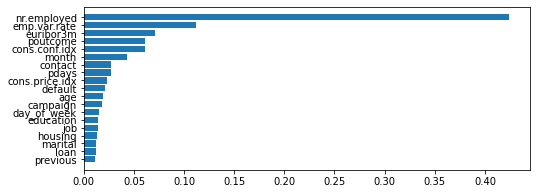

In [10]:
# Each XGBoost ensemble has its own feature importances
scores = xgb_search.best_estimator_.feature_importances_
features = Xtrn.columns.to_numpy()
srtd = np.argsort(scores)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.barh(y=features[srtd], width=scores[srtd])

---
### Modeling with Random Forests
The listing below shows how we can train an random forest ensemble over this data set

**Listing 9.4.** Training a random forest on the bank marketing data set

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_params = {'max_depth': [3, 5, 7],                # Maximum tree depth     
             'max_samples': [0.5, 0.6, 0.7, 0.8],   # Fraction of rows to sample
             'max_features': [0.5, 0.6, 0.7, 0.8],  # Fraction of columns to sample
             }

rf = RandomForestClassifier(class_weight={0: 1, 1: 10}, n_estimators=100) 
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=30, verbose=2, n_jobs=-1)
rf_search.fit(X=Xtrn, y=ytrn)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: 1, 1: 10}),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'max_features': [0.5, 0.6, 0.7, 0.8],
                                        'max_samples': [0.5, 0.6, 0.7, 0.8]},
                   verbose=2)

In [12]:
rf_search.best_score_

0.8327992383898699

In [13]:
rf_search.best_params_

{'max_samples': 0.5, 'max_features': 0.8, 'max_depth': 3}

<BarContainer object of 19 artists>

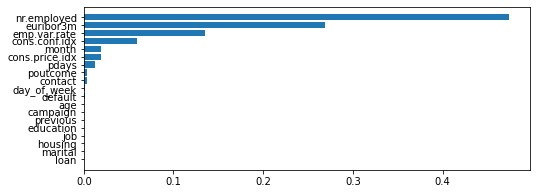

In [14]:
# Each random ensemble has its own feature importances
scores = rf_search.best_estimator_.feature_importances_
features = Xtrn.columns.to_numpy()
srtd = np.argsort(scores)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.barh(y=features[srtd], width=scores[srtd])

In [15]:
# Save the trained models as a pickle file
models = {'xgb': xgb_search.best_estimator_,
          'rf': rf_search.best_estimator_}

with open('./data/ch09/bank_marketing_models.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
# Load the trained models for visualization of feature importances
import pickle

with open('./data/ch09/bank_marketing_models.pickle', 'rb') as handle:
    models = pickle.load(handle)
print(models)

{'xgb': XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=1,
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...), 'rf': RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=3,
                       max_features=0.8, max_samples=0.5)}


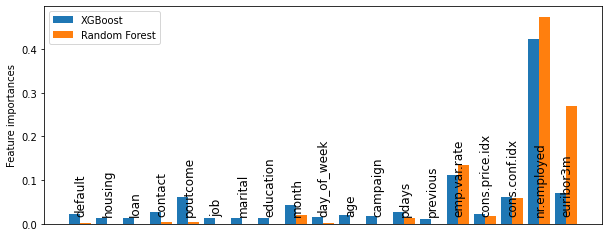

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

scores = np.column_stack([models['xgb'].feature_importances_,
                          models['rf'].feature_importances_])
features = Xtrn.columns.to_numpy()
# ax.bar(x=features, height=scores)
ax.bar(x=np.arange(0, len(features)) - 0.2, width=0.4, height=models['xgb'].feature_importances_)
ax.bar(x=np.arange(0, len(features)) + 0.2, width=0.4, height=models['rf'].feature_importances_)
for i, f in enumerate(features):
    ax.text(i-0.2, 0.025, f, rotation=90, fontsize=12)
ax.legend(['XGBoost', 'Random Forest'])
ax.set_ylabel('Feature importances')
ax.set_xticks([]);

pngFile = './figures/CH09_F06_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)